Currently Pulling SU
2020-07-16 20:08:41


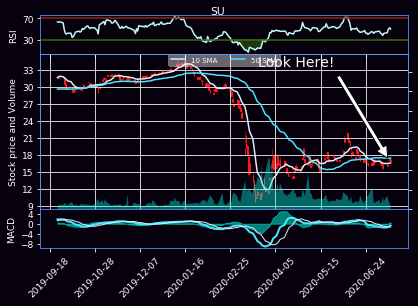

Currently Pulling TSLA
2020-07-16 20:08:45


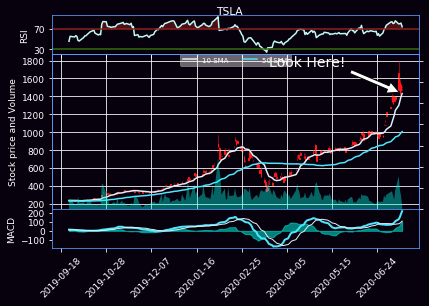

Currently Pulling GOOG
2020-07-16 20:08:48


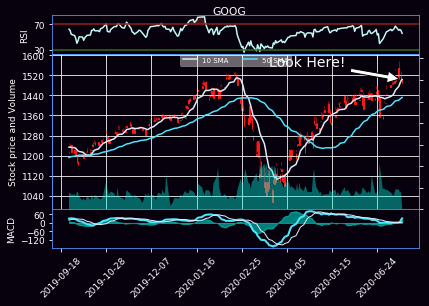

Currently Pulling TQQQ
2020-07-16 20:08:51


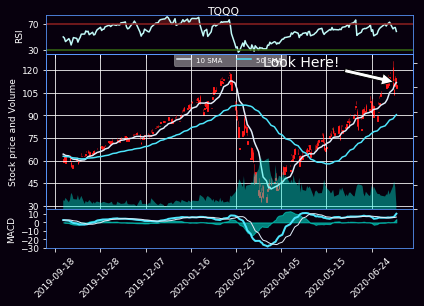

In [1]:
import import_ipynb
from urllib.request import urlopen
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import pandas_datareader.data as web
import matplotlib
import pylab
matplotlib.rcParams.update({'font.size': 9})

stocks = ['SU', 'TSLA', 'GOOG', 'TQQQ']


def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi


def movingaverage(values, window):
    weigths = np.repeat(1.0, window)/window
    smas = np.convolve(values, weigths, 'valid')
    return smas  # as a numpy array


def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a = np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a


def computeMACD(x, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow


def graphData(stock, MA1, MA2):
    '''
        Use this to dynamically pull a stock:
    '''
    try:
        start = datetime.datetime.now()-datetime.timedelta(days=365)
        end = datetime.datetime.now()
        print('Currently Pulling', stock)
        print(str(datetime.datetime.fromtimestamp(
            int(time.time())).strftime('%Y-%m-%d %H:%M:%S')))

        data = web.DataReader(stock, 'yahoo', start, end)
        stockFile = []
        try:

            stockFile.append(data)
        except Exception as e:
            print(str(e), 'failed to organize pulled data.')
    except Exception as e:
        print(str(e), 'failed to pull pricing data')
    try:
        date = [mdates.date2num(d) for d in data.index]
        closep = data['Close']
        highp = data['High']
        lowp = data['Low']
        openp = data['Open']
        volume = data['Volume']

        rsi = rsiFunc(closep)

        if rsi[-1] > 30:
            x = 0
            y = len(date)
            newAr = []
            while x < y:
                appendLine = date[x], openp[x], closep[x], highp[x], lowp[x], volume[x]
                newAr.append(appendLine)
                x += 1

            Av1 = movingaverage(closep, MA1)
            Av2 = movingaverage(closep, MA2)

            SP = len(date[MA2-1:])

            fig = plt.figure(facecolor='#07000d')

            ax1 = plt.subplot2grid(
                (6, 4), (1, 0), rowspan=4, colspan=4, facecolor='#07000d')
            candlestick_ohlc(ax1, newAr[-SP:], width=.6,
                             colorup='#53c156', colordown='#ff1717')

            Label1 = str(MA1)+' SMA'
            Label2 = str(MA2)+' SMA'

            ax1.plot(date[-SP:], Av1[-SP:], '#e1edf9',
                     label=Label1, linewidth=1.5)
            ax1.plot(date[-SP:], Av2[-SP:], '#4ee6fd',
                     label=Label2, linewidth=1.5)

            ax1.grid(False, color='w')
            ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax1.yaxis.label.set_color("w")
            ax1.spines['bottom'].set_color("#5998ff")
            ax1.spines['top'].set_color("#5998ff")
            ax1.spines['left'].set_color("#5998ff")
            ax1.spines['right'].set_color("#5998ff")
            ax1.tick_params(axis='y', colors='w')
            plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
            ax1.tick_params(axis='x', colors='w')
            plt.ylabel('Stock price and Volume')

            maLeg = plt.legend(loc=9, ncol=2, prop={'size': 7},
                               fancybox=True, borderaxespad=0.)
            maLeg.get_frame().set_alpha(0.4)
            textEd = pylab.gca().get_legend().get_texts()
            pylab.setp(textEd[0:5], color='w')

            volumeMin = 0

            ax0 = plt.subplot2grid(
                (6, 4), (0, 0), sharex=ax1, rowspan=1, colspan=4, facecolor='#07000d')
            # rsi = rsiFunc(closep)
            rsiCol = '#c1f9f7'
            posCol = '#386d13'
            negCol = '#8f2020'

            ax0.plot(date[-SP:], rsi[-SP:], rsiCol, linewidth=1.5)
            ax0.axhline(70, color=negCol)
            ax0.axhline(30, color=posCol)
            ax0.fill_between(date[-SP:], rsi[-SP:], 70, where=(rsi[-SP:]
                                                               >= 70), facecolor=negCol, edgecolor=negCol, alpha=0.5)
            ax0.fill_between(date[-SP:], rsi[-SP:], 30, where=(rsi[-SP:]
                                                               <= 30), facecolor=posCol, edgecolor=posCol, alpha=0.5)
            ax0.set_yticks([30, 70])
            ax0.yaxis.label.set_color("w")
            ax0.spines['bottom'].set_color("#5998ff")
            ax0.spines['top'].set_color("#5998ff")
            ax0.spines['left'].set_color("#5998ff")
            ax0.spines['right'].set_color("#5998ff")
            ax0.tick_params(axis='y', colors='w')
            ax0.tick_params(axis='x', colors='w')
            plt.ylabel('RSI')

            ax1v = ax1.twinx()
            ax1v.fill_between(date[-SP:], volumeMin,
                              volume[-SP:], facecolor='#00ffe8', alpha=.4)
            ax1v.axes.yaxis.set_ticklabels([])
            ax1v.grid(False)
            # Edit this to 3, so it's a bit larger
            ax1v.set_ylim(0, 3*volume.max())
            ax1v.spines['bottom'].set_color("#5998ff")
            ax1v.spines['top'].set_color("#5998ff")
            ax1v.spines['left'].set_color("#5998ff")
            ax1v.spines['right'].set_color("#5998ff")
            ax1v.tick_params(axis='x', colors='w')
            ax1v.tick_params(axis='y', colors='w')
            ax2 = plt.subplot2grid(
                (6, 4), (5, 0), sharex=ax1, rowspan=1, colspan=4, facecolor='#07000d')
            fillcolor = '#00ffe8'
            nslow = 26
            nfast = 12
            nema = 9
            emaslow, emafast, macd = computeMACD(closep)
            ema9 = ExpMovingAverage(macd, nema)
            ax2.plot(date[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
            ax2.plot(date[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
            ax2.fill_between(date[-SP:], macd[-SP:]-ema9[-SP:], 0,
                             alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)

            plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
            ax2.spines['bottom'].set_color("#5998ff")
            ax2.spines['top'].set_color("#5998ff")
            ax2.spines['left'].set_color("#5998ff")
            ax2.spines['right'].set_color("#5998ff")
            ax2.tick_params(axis='x', colors='w')
            ax2.tick_params(axis='y', colors='w')
            plt.ylabel('MACD', color='w')
            ax2.yaxis.set_major_locator(
                mticker.MaxNLocator(nbins=5, prune='upper'))
            for label in ax2.xaxis.get_ticklabels():
                label.set_rotation(45)

            plt.suptitle(stock.upper(), color='w')

            plt.setp(ax0.get_xticklabels(), visible=False)
            plt.setp(ax1.get_xticklabels(), visible=False)

            ax1.annotate('Look Here!', (date[-1], Av1[-1]),
                         xytext=(0.8, 0.9), textcoords='axes fraction',
                         arrowprops=dict(facecolor='white', shrink=0.05),
                         fontsize=14, color='w',
                         horizontalalignment='right', verticalalignment='bottom')

            plt.subplots_adjust(left=.09, bottom=.14,
                                right=.94, top=.95, wspace=.20, hspace=0)

            plt.show()
            fig.savefig('example.png', facecolor=fig.get_facecolor())

    except Exception as e:
        print('main loop', str(e))


for stock in stocks:
    graphData(stock, 10, 50)